In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

2023-03-26 13:14:35.993481: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:14:39.645680: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-26 13:14:51.958597: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('data/train.csv')

In [4]:
df=df.iloc[:1000000,:]

In [5]:
df.rename(columns={'itemId':'movieId'} , inplace=True)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   userId   1000000 non-null  object 
 1   movieId  1000000 non-null  int64  
 2   rating   1000000 non-null  float32
 3   date     1000000 non-null  object 
 4   user     1000000 non-null  int64  
 5   movie    1000000 non-null  int64  
dtypes: float32(1), int64(3), object(2)
memory usage: 42.0+ MB


In [7]:
df.head(1)

,userId,movieId,rating,date
0,cgexjc,682978,4,2017-08-13 13:23:35


In [34]:
# df["rating"] = pd.to_numeric(df["rating"], downcast="float" , errors = 'coerce')


In [8]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 6483, Number of Movies: 27011, Min rating: 1.0, Max rating: 5.0


In [14]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [15]:
train_indices

90000

In [16]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

2023-03-26 06:03:23.579543: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-26 06:03:23.623432: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-26 06:03:23.623544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (17a2d1018da2): /proc/driver/nvidia/version does not exist


In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/5
1407/1407 [==============================] - 29s 18ms/step - loss: 0.6622 - val_loss: 0.6475
Epoch 2/5
1407/1407 [==============================] - 24s 17ms/step - loss: 0.6398 - val_loss: 0.6397
Epoch 3/5
1407/1407 [==============================] - 20s 14ms/step - loss: 0.6333 - val_loss: 0.6345
Epoch 4/5
1407/1407 [==============================] - 24s 17ms/step - loss: 0.6312 - val_loss: 0.6344
Epoch 5/5
1407/1407 [==============================] - 27s 19ms/step - loss: 0.6290 - val_loss: 0.6320


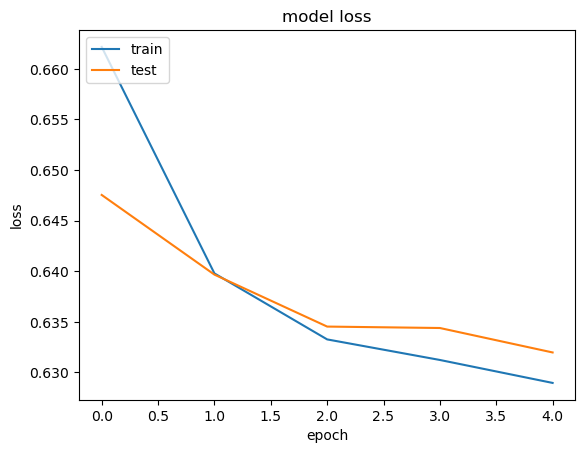

In [18]:

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [9]:
testdf = pd.read_csv('data/test.csv')
testdf.rename(columns={'itemId':'movieId'} , inplace=True)
testdf['user']=testdf['userId'].apply(lambda x: user2user_encoded.get(x))
testdf['movie']=testdf['movieId'].apply(lambda x: movie2movie_encoded.get(x))

In [ ]:
testdf['rating']=testdf.apply(lambda x: model.predict(x.user , x.movie) , axis=1)

In [29]:
testdf

,userId,movieId,date,user,movie
0,cgexjc,857869,2021-08-18 00:40:19,0.0,559.0
1,cgexjc,631765,2021-08-18 01:31:23,0.0,1583.0
2,cgexjc,232633,2021-08-18 01:12:46,0.0,2190.0
3,cgexjc,259982,2021-08-18 00:50:49,0.0,1584.0
4,cgexjc,131945,2021-08-18 00:56:13,0.0,1232.0
...,...,...,...,...,...
131353,yzesmd,388934,2021-07-30 08:48:06,NaN,2008.0
131354,yzesmd,571188,2021-07-30 08:49:17,NaN,12657.0
131355,yzesmd,707682,2021-07-30 08:49:40,NaN,14747.0
131356,yzesmd,44761,2021-07-30 08:48:55,NaN,4455.0


In [28]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131358 entries, 0 to 131357
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   131358 non-null  object 
 1   movieId  131358 non-null  int64  
 2   date     131358 non-null  object 
 3   user     17928 non-null   float64
 4   movie    120758 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.0+ MB


In [19]:
user_id = testdf.userId.sample(1).iloc[0]
user_id='cgexjc'

In [20]:
user_id

'cgexjc'

In [21]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

0

In [16]:
user2user_encoded

{'cgexjc': 0,
 'vprmmq': 1,
 'mkxnry': 2,
 'ubuibh': 3,
 'qwasoh': 4,
 'bmhcqu': 5,
 'xnghyg': 6,
 'nfjkad': 7,
 'njkltg': 8,
 'hoffhj': 9,
 'rfogju': 10,
 'ewwnps': 11,
 'txdmvc': 12,
 'ibwwij': 13,
 'kiectn': 14,
 'zoppcp': 15,
 'irldih': 16,
 'mrnpsf': 17,
 'uibhzu': 18,
 'xlnkwl': 19,
 'vgpkpq': 20,
 'jqmiup': 21,
 'gvhfrg': 22,
 'vwlosu': 23,
 'pawbrd': 24,
 'tqifpg': 25,
 'uvndng': 26,
 'jgzqaw': 27,
 'uhpzsp': 28,
 'tygzna': 29,
 'loicnl': 30,
 'nrmkcb': 31,
 'yeneac': 32,
 'yrxbuz': 33,
 'wixwlb': 34,
 'uurcnr': 35,
 'xhxaqo': 36,
 'cblnva': 37,
 'nqzwhi': 38,
 'eesytw': 39,
 'jrqvqu': 40,
 'irwcmp': 41,
 'rakdqt': 42,
 'dvtbuw': 43,
 'jchfuc': 44,
 'pwyoia': 45,
 'cvmczr': 46,
 'ezpmbk': 47,
 'znxdcb': 48,
 'cstssd': 49,
 'pjxjgy': 50,
 'tmxafe': 51,
 'kpxlpa': 52,
 'yeixps': 53,
 'qxkvdu': 54,
 'bsztkv': 55,
 'ojisiw': 56,
 'dxtdek': 57,
 'aomqrf': 58,
 'undxzz': 59,
 'yiyzcq': 60,
 'hvabul': 61,
 'ansxpb': 62,
 'kghhrg': 63,
 'lprqkq': 64,
 'cralxm': 65,
 'qthawj': 66,
 'jja

In [ ]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]

user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)